### Approximate BNN pattern analysis

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from gen_data import *
sns.set(font_scale=1.2)
sns.set_theme(style='white')
figsize=(8,6)

#### Input pattern

In [2]:
X_train, _ = load_data('./data/', 'residual_train.pkl')
X_train2, _ = load_data('./data/', 'complex_train.pkl')

In [5]:
X_train.any() == X_train2.any()

tensor(True, device='cuda:0')

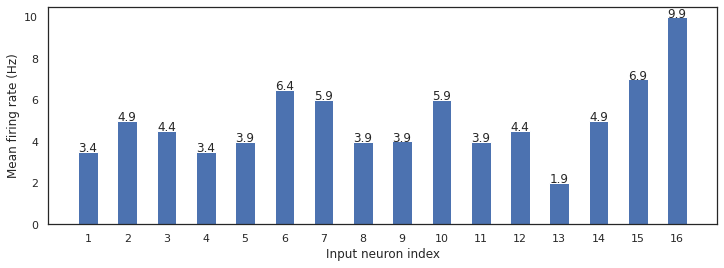

In [3]:
plt.figure(figsize=(12,4))
w = 1
    
means = np.zeros(16)
for j in range(16):
    means[j] = torch.mean(X_train[:,:,j])
    
plt.bar(np.arange(16),means, 0.5*w)

for i in range(16):
    plt.text(i, means[i], str(means[i])[:3], ha='center')

plt.xticks([])
plt.xticks(np.arange(16), np.arange(1,17))
plt.ylabel('Mean firing rate (Hz)')
plt.xlabel('Input neuron index')
plt.savefig('./figures/input_firing_rates.png', dpi=350, bbox_inches='tight')
plt.show()

##### Fano Factor

In [11]:
def fano_factor(spike_trains):
    '''
    Computes the Fano factor of spike trains
    The fano factor is defined as the ratio of the variance to the mean of a repetition
    :param spike_trains: [n_trials, n_time_steps, n_independent_dims]
    '''
    mean = torch.mean(torch.sum(spike_trains, dim=1), dim=0)
    std = torch.std(torch.sum(spike_trains, dim=1), dim=0)
    return std ** 2 / mean
                      
fano_factor(X_train[:100,:,:])

tensor([0.3566, 0.5221, 0.3628, 0.4280, 0.4934, 0.5494, 0.5161, 0.5749, 0.5331,
        0.5599, 0.4781, 0.4475, 0.4516, 0.4496, 0.4068, 0.4723],
       device='cuda:0')

In [5]:
# computes the entropy of a tensor
def calc_entropy(x:torch.Tensor):
    '''
    Computes the (Shannon) entropy of a tensor based on its empirical distribution
    '''
    x = x.flatten()
    freq = x.unique(return_counts=True)[1]
    probs = freq/torch.sum(freq)
    return -torch.multiply(probs, torch.log(probs)).sum()

#### Output pattern

In [7]:
_, Y_ff = load_data('./data/','feedforward_train_nonoise.pkl')
_, Y_resid = load_data('./data/','residual_train_nonoise.pkl')
_, Y_recur = load_data('./data/','recurrent_train_nonoise.pkl')
_, Y_cplx = load_data('./data/','complex_train_nonoise.pkl')
Ys = [Y_ff, Y_resid, Y_recur, Y_cplx]
d = {0: 'Feed-forward ABNN',
     1: 'Skip ABNN',
     2: 'Feed-back ABNN',
     3: 'Complex ABNN'}

In [8]:
# Y: 10000 data points, 50 time steps, 16 dimensions
d[0]

'Feed-forward ABNN'

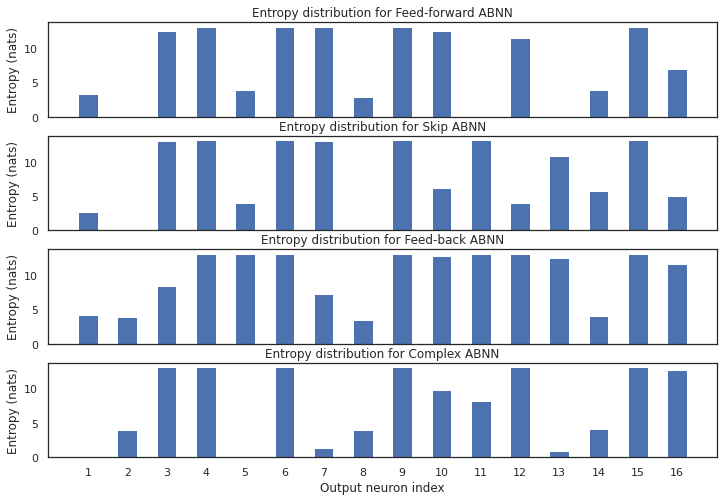

In [9]:
plt.figure(figsize=(12,8))
for i in range(4):
    plt.subplot(4,1,i+1)
    w = 1
    
    entropies = np.zeros(16)
    for j in range(16):
        entropies[j] = calc_entropy(Ys[i][:,:,j])
    
    plt.bar(np.arange(16) ,entropies, 0.5*w)
    plt.xticks([])
    # plt.xlabel('Output neuron')
    plt.ylabel('Entropy (nats)')
    plt.title(f'Entropy distribution for {d[i]}')
plt.xticks(np.arange(16), np.arange(1,17))
plt.xlabel('Output neuron index')
plt.savefig('./figures/entropy_distributions.png', dpi=350, bbox_inches='tight')
plt.show()

In [10]:
# principal component analysis of output

# standardise data
Z_scored_Y = [normalise_data(Y.view(-1,16)) for Y in Ys] # normalise data
Z_scored_Y = [Y.cpu().numpy() for Y in Z_scored_Y]
covs = [np.cov(Y.T) for Y in Z_scored_Y]

pcas = []

for i in range(len(covs)):
    eigenvals, eigenvecs = np.linalg.eig(covs[i])
    idx = eigenvals.argsort()[::-1]   
    eigenvals = eigenvals[idx]
    eigenvecs = eigenvecs[:,idx].T
    pcas.append(Z_scored_Y[i] @ eigenvecs[:3].T)


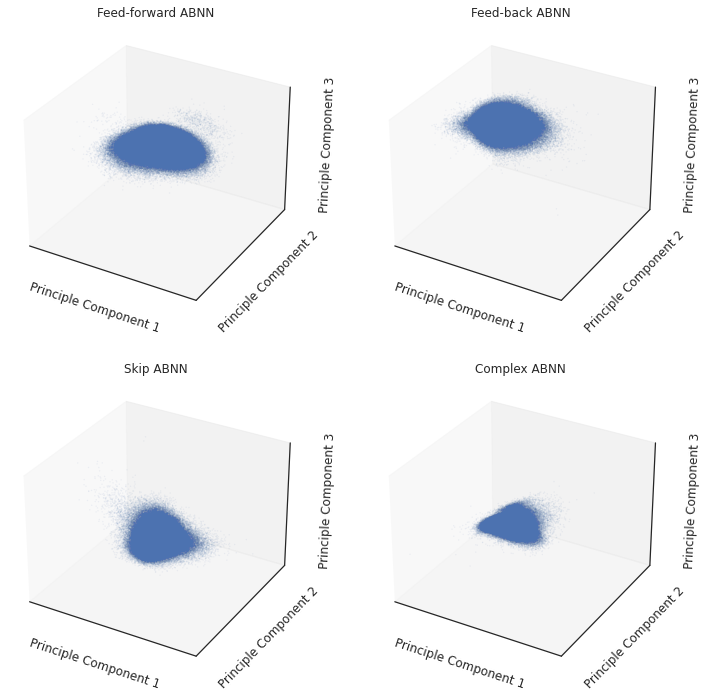

In [13]:
fig, axs = plt.subplots(2, 2, subplot_kw=dict(projection="3d"), figsize=(12,12))

axs[0,0].scatter(pcas[0][:,0], pcas[0][:,1], pcas[0][:,2], s=0.1, alpha=0.1)
axs[0,0].set_title(f'{d[0]}')
axs[1,0].scatter(pcas[1][:,0], pcas[1][:,1], pcas[1][:,2], s=0.1, alpha=0.1)
axs[1,0].set_title(f'{d[1]}')
axs[0,1].scatter(pcas[2][:,0], pcas[2][:,1], pcas[2][:,2], s=0.1, alpha=0.1)
axs[0,1].set_title(f'{d[2]}')
axs[1,1].scatter(pcas[3][:,0], pcas[3][:,1], pcas[3][:,2], s=0.1, alpha=0.1)
axs[1,1].set_title(f'{d[3]}')


for i in axs:
    for ax in i:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

        ax.set_xlabel('Principle Component 1')
        ax.set_ylabel('Principle Component 2')
        ax.set_zlabel('Principle Component 3')


plt.savefig('./figures/pcas.png', dpi=350, bbox_inches='tight')
plt.show()